### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from googletrans import Translator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import nltk

nltk.download('stopwords')
import tensorflow as tf

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\davia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
translator = Translator()

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

### Importing Data

In [4]:
data = pd.read_csv("./Movie reviews.csv")
print(data)

print(f'There are {len(data)} quotes in this dataset.')

                                                Review  Score  \
0    Filem ini hebat! Aksi yang mendebarkan dan plo...    0.1   
1    Filem ini hebat! Aksi yang mendebarkan dan plo...    0.9   
2    Filem ini hebat! Aksi yang mendebarkan dan plo...    0.5   
3    Sayang sekali, pelakon tidak memberikan persem...    0.8   
4    Jalan cerita yang kompleks dan penuh emosi. Su...    0.2   
..                                                 ...    ...   
522                                             Pening    0.7   
523                                           Berkesan    0.2   
524                                         Mengujakan    0.1   
525                                Sederhana and teruk    0.6   
526                                           Sempurna    0.1   

     Are there ways for you to generate more data? Spliting up sentences, would that help?  \
0                                                  NaN                                       
1                              

In [5]:
data.dtypes

Review                                                                                    object
Score                                                                                    float64
Are there ways for you to generate more data? Spliting up sentences, would that help?    float64
Language                                                                                  object
dtype: object

### Data Pre-processing

In [6]:
data.drop(['Are there ways for you to generate more data? Spliting up sentences, would that help?'], axis='columns', inplace=True)

Thanks cher for the hint :)

In [7]:
# Check for review duplicates
print(f'There are {len(data["Review"])} reviews in this dataset.')
print(f'There are {len(data["Review"].unique())} unique reviews in this dataset.')

There are 527 reviews in this dataset.
There are 405 unique reviews in this dataset.


I will start by dropping rows which all columns has the same value

In [8]:
data.drop_duplicates(inplace=True)

In [9]:
# Group the data by review and count the number of times each review appears and show those with more than one count
review_counts = data.groupby('Review').size()
review_counts = review_counts[review_counts > 1]
review_counts = review_counts.index.tolist()

In [10]:
review_counts

['Complex',
 'Filem ini hebat! Aksi yang mendebarkan dan plot yang mengejutkan.',
 'Filem ini membuat saya gelak dan menangis. Suka dengan perasaan yang disampaikan.',
 'Intriguing',
 'Keseluruhan, filem ini hebat! Saya akan menontonnya lagi.',
 'Lack of character development makes this film weak. Not satisfying.',
 'Pelakon tidak berjaya membawa watak dengan baik. Kurang kredibel.',
 'Saya tidak suka bagaimana filem ini berakhir. Tidak memuaskan.',
 'The visual effects and animation in this film are amazing. Impressed!',
 'Weak']

I will manually go through each duplicated review and remove it if appropriate

In [11]:
data[data['Review'] == review_counts[2]]

,Review,Score,Language
24,Filem ini membuat saya gelak dan menangis. Suk...,0.15,Malay
121,Filem ini membuat saya gelak dan menangis. Suk...,0.20,Malay


- Not removing 'Complex' as it has a score of 0.65 and 0.10 as 'Complex' can have a negative and positive connotation to it
- 'Filem ini hebat! Aksi yang mendebarkan dan plo...' is actually positive when using Google Translate so I will remove the duplicates with negative score
- "Keseluruhan, filem ini hebat! Saya akan menontonnya lagi." is positive so I will remove the negatively score one

In [12]:
data.drop(index=[1,2], inplace=True)

In [13]:
def remove_duplicate_set_average(index_array):
    for index in index_array:
        average_score = round(data[data['Review'] == review_counts[index]]['Score'].mean(),2)
        data.drop(index=data[data['Review'] == review_counts[index]].index[1:], inplace=True)
        data.loc[data['Review'] == review_counts[index], 'Score'] = average_score

For duplicates which are under the same classification (positive, negative) I will average out their score.

In [14]:
remove_duplicate_set_average([2,3,4,5,6,7,8,9])

In [15]:
review_counts = data.groupby('Review').size()
review_counts = review_counts[review_counts > 1]

review_counts

Review
Complex    2
dtype: int64

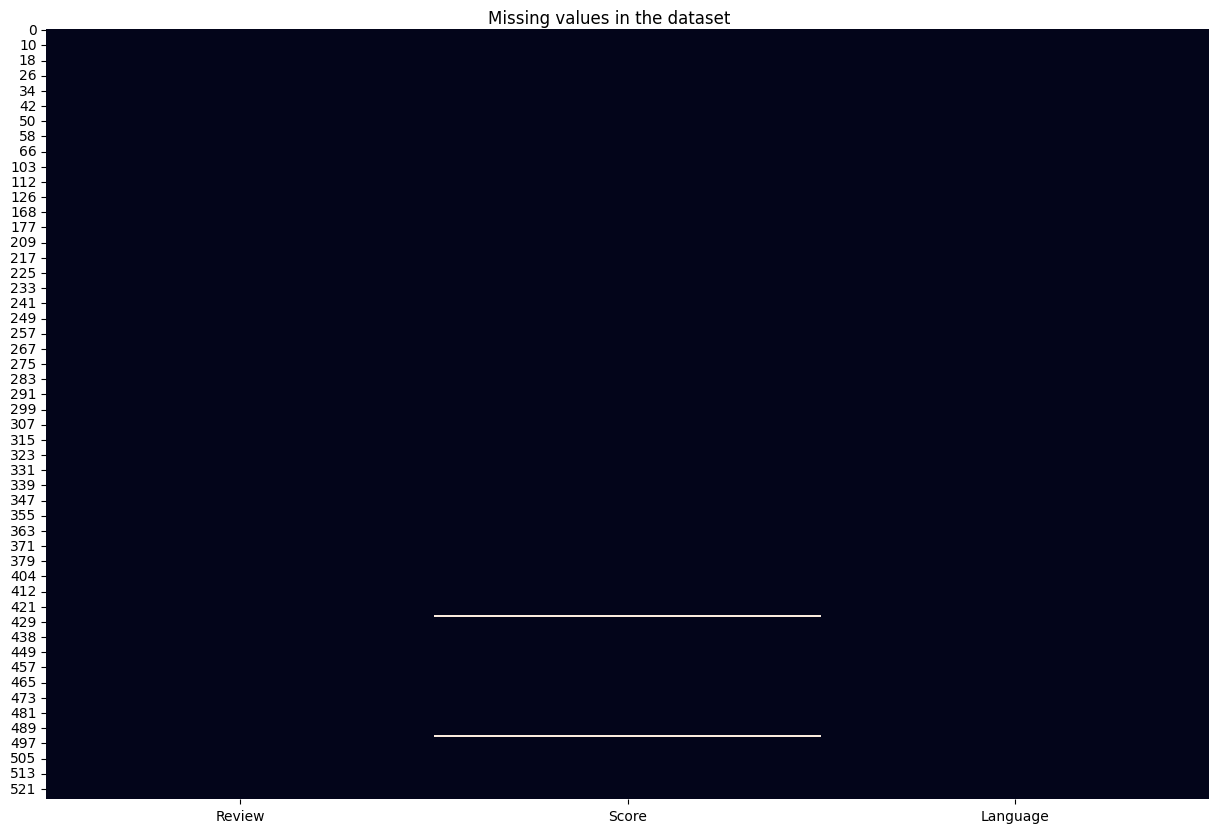

In [16]:
fig = plt.figure(figsize = (15,10))
plt.suptitle("Missing values in the dataset", y = 0.90)
sns.heatmap(data.isnull(), cbar = False)
plt.show()

In [17]:
data[data['Score'].isnull()]

,Review,Score,Language
426,Ni hao,NaN,Chinese
493,Diabolic,NaN,English


As there are 2 null rows, which is a pretty small amount, I can remove them

In [18]:
data.dropna(inplace=True)

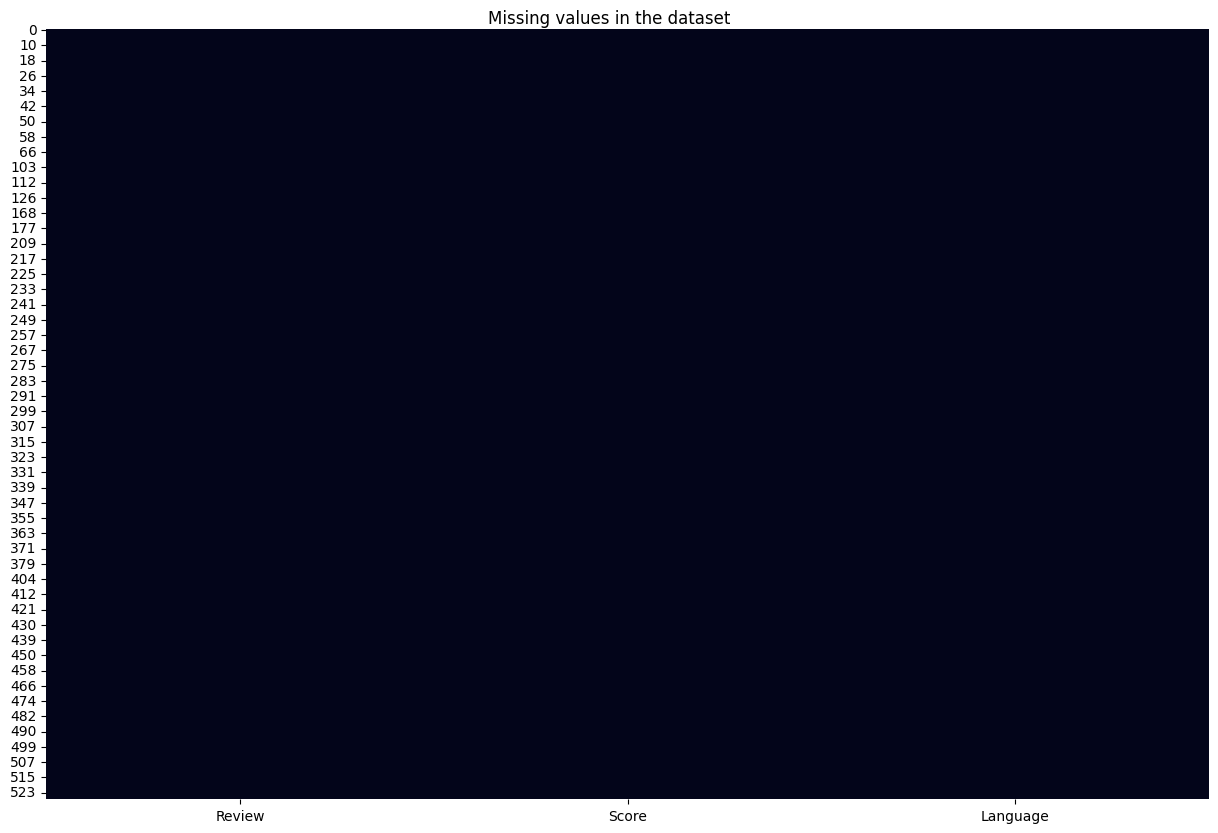

In [19]:
fig = plt.figure(figsize = (15,10))
plt.suptitle("Missing values in the dataset", y = 0.90)
sns.heatmap(data.isnull(), cbar = False)
plt.show()

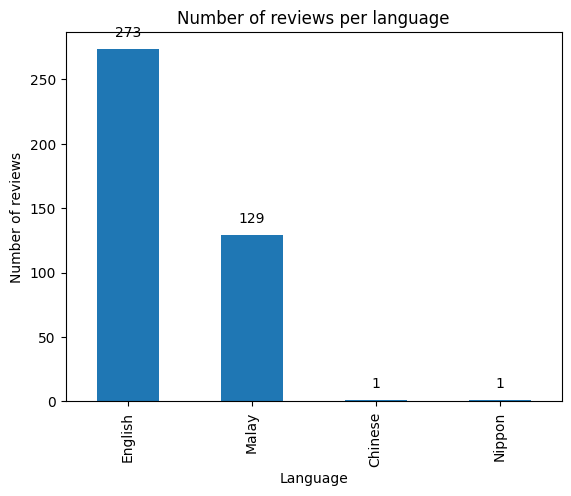

In [20]:
data['Language'].value_counts().plot(kind='bar')
for i, v in enumerate(data['Language'].value_counts()):
    plt.text(i, v + 10, str(v), ha = 'center')
plt.title('Number of reviews per language')
plt.ylabel('Number of reviews')
plt.show()


As Chinese and Nippon only has 1 data in it each, it would only make sense to remove it entirely. As the English dataset has only 273 sets of data in it which isn't alot, I will convert the Malay dataset into English so that we will have a larger dataset.

In [21]:
data = data[data['Language'] != 'Chinese']
data = data[data['Language'] != 'Nippon']

In [22]:
data.loc[data['Language'] == 'Malay', 'Review'] = data[data['Language'] == 'Malay']['Review'].apply(lambda x: translator.translate(x, src='ms', dest='en').text)

In [23]:
data.drop('Language', axis=1, inplace=True)
data

,Review,Score
0,This movie is great!Thrilling action and shock...,0.10
3,"Unfortunately, the actor didn't give the best ...",0.80
4,Complex and emotional storyline.So entertaining!,0.20
5,The filmmaker succeeded in providing an unforg...,0.05
6,Excessive and shocking action scenes.Sometimes...,0.40
...,...,...
522,Dizzy,0.70
523,Effective,0.20
524,Exciting,0.10
525,Moderate and severe,0.60


We will remove stopwords which are words that do not carry significant meaning and can be ignored.

In [24]:
# Remove stopwords
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

data['Review'] = data['Review'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))

data

,Review,Score
0,movie great ! Thrilling action shocking plot .,0.10
3,"Unfortunately , actor n't give best performanc...",0.80
4,Complex emotional storyline.So entertaining !,0.20
5,filmmaker succeeded providing unforgettable ex...,0.05
6,Excessive shocking action scenes.Sometimes 's ...,0.40
...,...,...
522,Dizzy,0.70
523,Effective,0.20
524,Exciting,0.10
525,Moderate severe,0.60


We will do classification for this dataset as the dataset is quite small and it will be easier for the model to predict discrete classes rather than a continuous range. If score is >0.5 then review is negative else positive. Replace Score with 0 for negative and 1 for positive

In [25]:
data['Score'] = data['Score'].apply(lambda x: 0 if x > 0.5 else 1)

In [26]:
data

,Review,Score
0,movie great ! Thrilling action shocking plot .,1
3,"Unfortunately , actor n't give best performanc...",0
4,Complex emotional storyline.So entertaining !,1
5,filmmaker succeeded providing unforgettable ex...,1
6,Excessive shocking action scenes.Sometimes 's ...,1
...,...,...
522,Dizzy,0
523,Effective,1
524,Exciting,1
525,Moderate severe,0


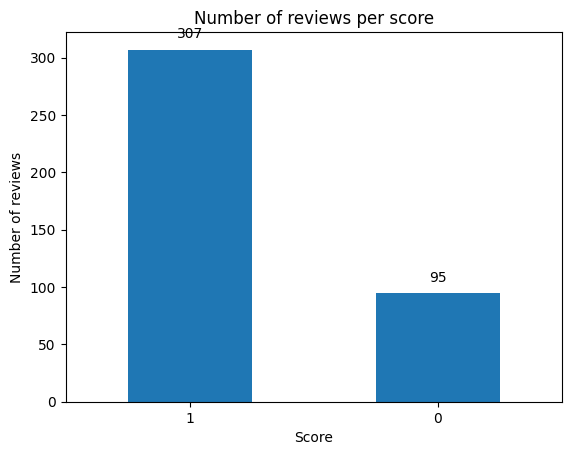

In [27]:
data['Score'].value_counts().plot(kind='bar')
for i, v in enumerate(data['Score'].value_counts()):
    plt.text(i, v + 10, str(v), ha = 'center')
plt.title('Number of reviews per score')
plt.ylabel('Number of reviews')
plt.xticks(rotation=0)
plt.show()

There are still not a lot of data to work with. To help increase the dataset size, we will split up sentences in the reviews.

In [28]:
# split the negative sentiment data sentence by sentence to generate more data
negative_data = data[data['Score'] == 0]

negative_data['Review'] = negative_data['Review'].apply(lambda x: x.split('.'))
negative_data = negative_data.explode('Review')

negative_data['Review'] = negative_data['Review'].apply(lambda x: x.split('!'))
negative_data = negative_data.explode('Review')

# Remove empty strings
negative_data = negative_data[negative_data['Review'] != '']

negative_data

C:\Users\davia\AppData\Local\Temp\ipykernel_18512\1688256757.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_data['Review'] = negative_data['Review'].apply(lambda x: x.split('.'))


,Review,Score
3,"Unfortunately , actor n't give best performance",0
3,Disappointed,0
8,Avengers : Endgame frustrating boring,0
8,Too many clichings,0
12,think movie good says,0
...,...,...
511,Sad,0
516,Unsatisfactory,0
520,Chaos,0
522,Dizzy,0


In [29]:
# split the negative sentiment data sentence by sentence to generate more data
positive_data = data[data['Score'] == 1]

positive_data['Review'] = positive_data['Review'].apply(lambda x: x.split('.'))
positive_data = positive_data.explode('Review')

positive_data['Review'] = positive_data['Review'].apply(lambda x: x.split('!'))
positive_data = positive_data.explode('Review')

# Remove empty strings
positive_data = positive_data[positive_data['Review'] != '']

positive_data

C:\Users\davia\AppData\Local\Temp\ipykernel_18512\3780834349.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_data['Review'] = positive_data['Review'].apply(lambda x: x.split('.'))


,Review,Score
0,movie great,1
0,Thrilling action shocking plot,1
4,Complex emotional storyline,1
4,So entertaining,1
5,filmmaker succeeded providing unforgettable ex...,1
...,...,...
519,Fabulous,1
521,Adorable,1
523,Effective,1
524,Exciting,1


Merge the augmented positive data with the augmented negative data

In [30]:
data = pd.concat([positive_data, negative_data], ignore_index=True)

Check for duplicates after all the preprocessing and drop duplicates if necessary

In [31]:
# Group the data by review and count the number of times each review appears and show those with more than one count
review_counts = data.groupby('Review').size()
review_counts = review_counts[review_counts > 1]
review_counts = review_counts.index.tolist()

In [32]:
len(review_counts)

51

In [33]:
data.drop_duplicates(inplace=True)

In [34]:
# Group the data by review and count the number of times each review appears and show those with more than one count
review_counts = data.groupby('Review').size()
review_counts = review_counts[review_counts > 1]
review_counts = review_counts.index.tolist()

In [35]:
data[data['Review'] == review_counts[1]]

,Review,Score
482,Epic,1
726,Epic,0


We will remove Epic from the negative class

In [36]:
data.drop(index=[726], inplace=True)

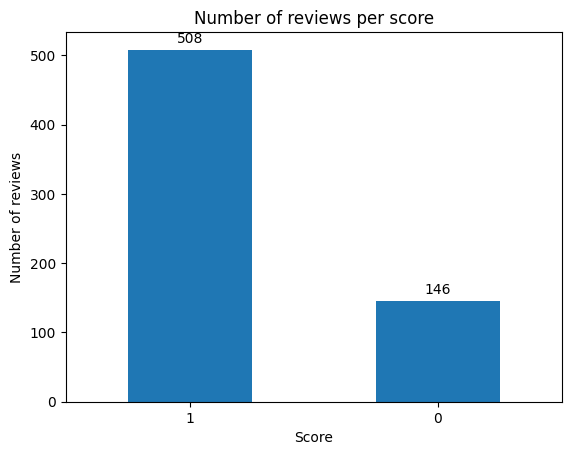

In [37]:
data['Score'].value_counts().plot(kind='bar')
for i, v in enumerate(data['Score'].value_counts()):
    plt.text(i, v + 10, str(v), ha = 'center')
plt.title('Number of reviews per score')
plt.ylabel('Number of reviews')
plt.xticks(rotation=0)
plt.show()

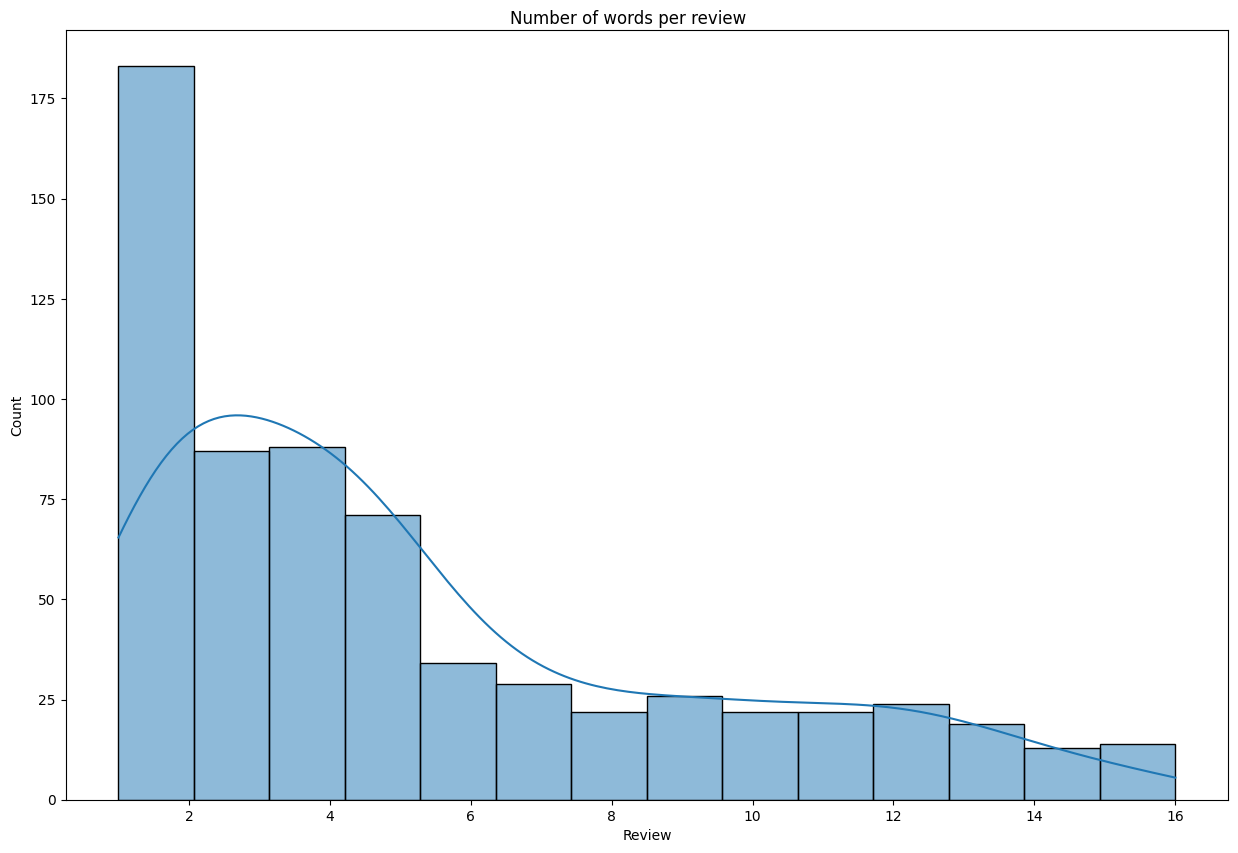

In [38]:
fig = plt.figure(figsize = (15,10))
plt.suptitle("Number of words per review", y = 0.90)
sns.histplot(data["Review"].str.split().map(lambda x: len(x)), kde = True)
plt.show()

From the graph, most of the reviews seems to be 1 word. The distribution is positively skewed.

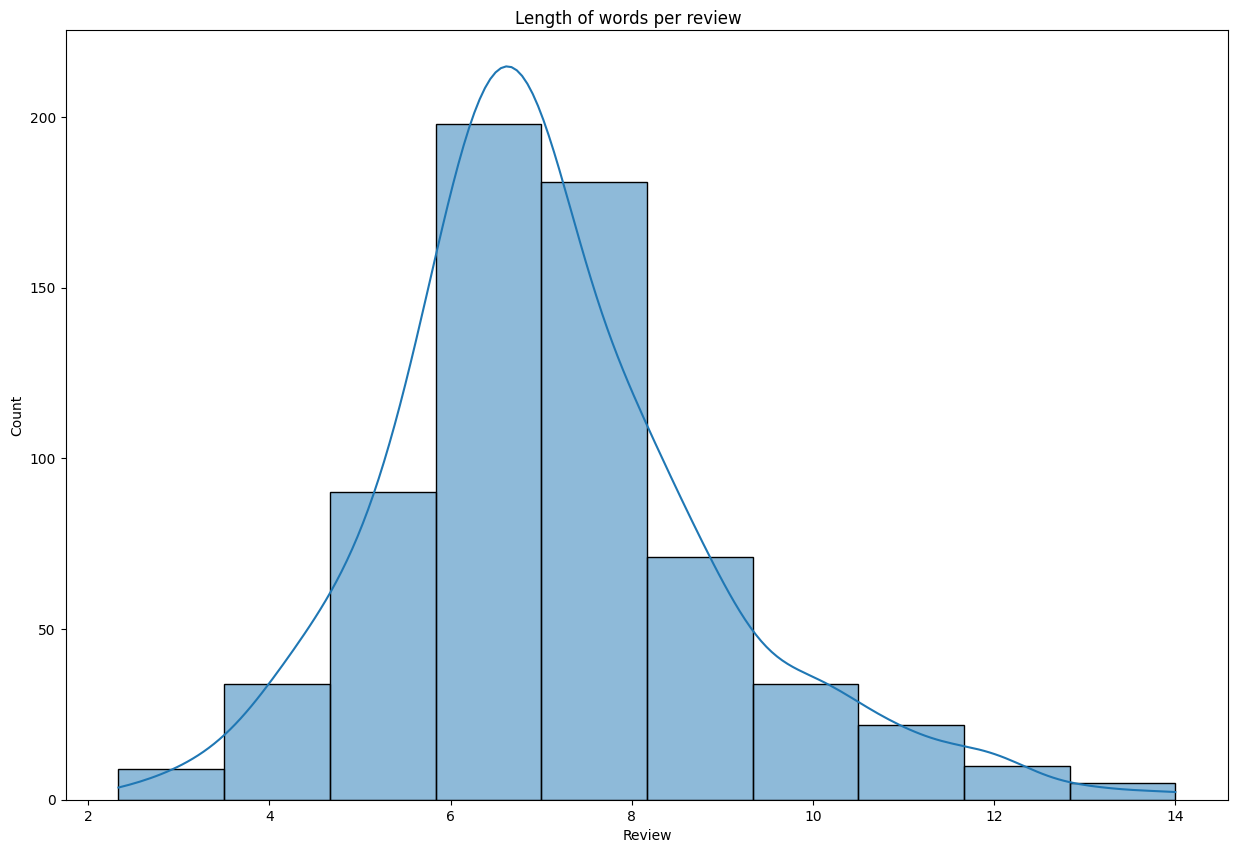

In [39]:
fig = plt.figure(figsize = (15,10))
plt.suptitle("Length of words per review", y = 0.90)
sns.histplot(data["Review"].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)), kde = True, bins = 10)
plt.show()

From the graph we can see that the average word length ranges between 2 to 14 with 6 being the most common.

### Tokenization

I will now tokenise the reviews

In [40]:
#tokenise the reviews
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Review'])

vocab_size = len(tokenizer.word_index) + 1

print(f'There are {vocab_size} unique words in the dataset.')

tokenised_word = tokenizer.texts_to_sequences(data['Review'])
tokenised_word = pad_sequences(tokenised_word, padding='pre')

tokenised_word.shape

There are 756 unique words in the dataset.


(654, 14)

In [41]:
score = data['Score'].values

score.shape

(654,)

### Train-Test-Validation Split

We will be doing a 70-15-15 Split as the dataset is quite small. We will use stratify to keep a stratified split as the data is imabalanced.

In [42]:
# train test validation split 70-15-15
X_train, X_test, y_train, y_test = train_test_split(tokenised_word, score, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

Train set has 102 negative reviews and 355 positive reviews.
Validation set has 22 negative reviews and 76 positive reviews.
Test set has 22 negative reviews and 77 positive reviews.


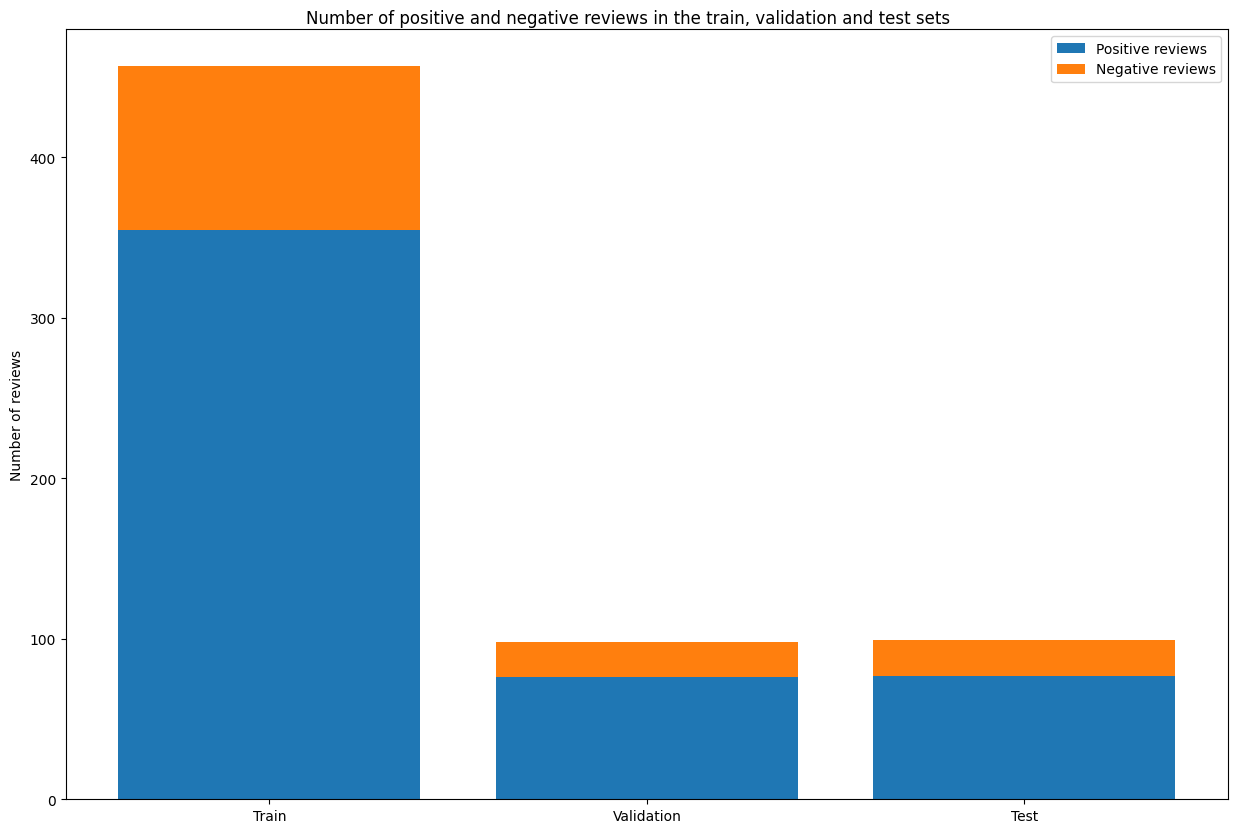

In [43]:
print(f'Train set has {len(y_train) - np.sum(y_train)} negative reviews and {np.sum(y_train)} positive reviews.')
print(f'Validation set has {len(y_val) - np.sum(y_val)} negative reviews and {np.sum(y_val)} positive reviews.')
print(f'Test set has {len(y_test) - np.sum(y_test)} negative reviews and {np.sum(y_test)} positive reviews.')

fig = plt.figure(figsize = (15,10))
plt.suptitle("Number of positive and negative reviews in the train, validation and test sets", y = 0.90)
plt.bar(['Train', 'Validation', 'Test'], [np.sum(y_train), np.sum(y_val), np.sum(y_test)], label='Positive reviews')
plt.bar(['Train', 'Validation', 'Test'], [len(y_train) - np.sum(y_train), len(y_val) - np.sum(y_val), len(y_test) - np.sum(y_test)], label='Negative reviews', bottom=[np.sum(y_train), np.sum(y_val), np.sum(y_test)])
plt.ylabel('Number of reviews')
plt.legend()
plt.show()

To help counteract the class imbalance, we will use the class weight

In [44]:
from sklearn.utils.class_weight import compute_class_weight

def generate_class_weights(class_series): 
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  
class_weights = generate_class_weights(y_train)

### Model

In [45]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=tokenised_word.shape[1]))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 100)           75600     
                                                                 
 bidirectional (Bidirectiona  (None, 14, 64)           34048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 64)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4

To improve the model, I added dropout to prevent overfitting, played around with the amount and type of layers and the number of neurons

The learning rate of Adam was set to 0.0001 to help reduce volatility in the loss and accuracy scores.

This model has a total of 179,857 trainable parameters

In [46]:
# Train the model

history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_val, y_val), verbose=1, class_weight=class_weights)

Epoch 1/100
46/46 [==============================] - 13s 34ms/step - loss: 1.1836 - accuracy: 0.5624 - val_loss: 1.1655 - val_accuracy: 0.5204
Epoch 2/100
46/46 [==============================] - 1s 11ms/step - loss: 1.1494 - accuracy: 0.5077 - val_loss: 1.1328 - val_accuracy: 0.5714
Epoch 3/100
46/46 [==============================] - 1s 12ms/step - loss: 1.1174 - accuracy: 0.5230 - val_loss: 1.1034 - val_accuracy: 0.3776
Epoch 4/100
46/46 [==============================] - 1s 13ms/step - loss: 1.0867 - accuracy: 0.5558 - val_loss: 1.0736 - val_accuracy: 0.5102
Epoch 5/100
46/46 [==============================] - 1s 12ms/step - loss: 1.0585 - accuracy: 0.6039 - val_loss: 1.0451 - val_accuracy: 0.5714
Epoch 6/100
46/46 [==============================] - 1s 12ms/step - loss: 1.0302 - accuracy: 0.5361 - val_loss: 1.0221 - val_accuracy: 0.4796
Epoch 7/100
46/46 [==============================] - 1s 12ms/step - loss: 1.0000 - accuracy: 0.6783 - val_loss: 0.9919 - val_accuracy: 0.5816
Epoch

4/4 [==============================] - 0s 7ms/step - loss: 0.7279 - accuracy: 0.8586


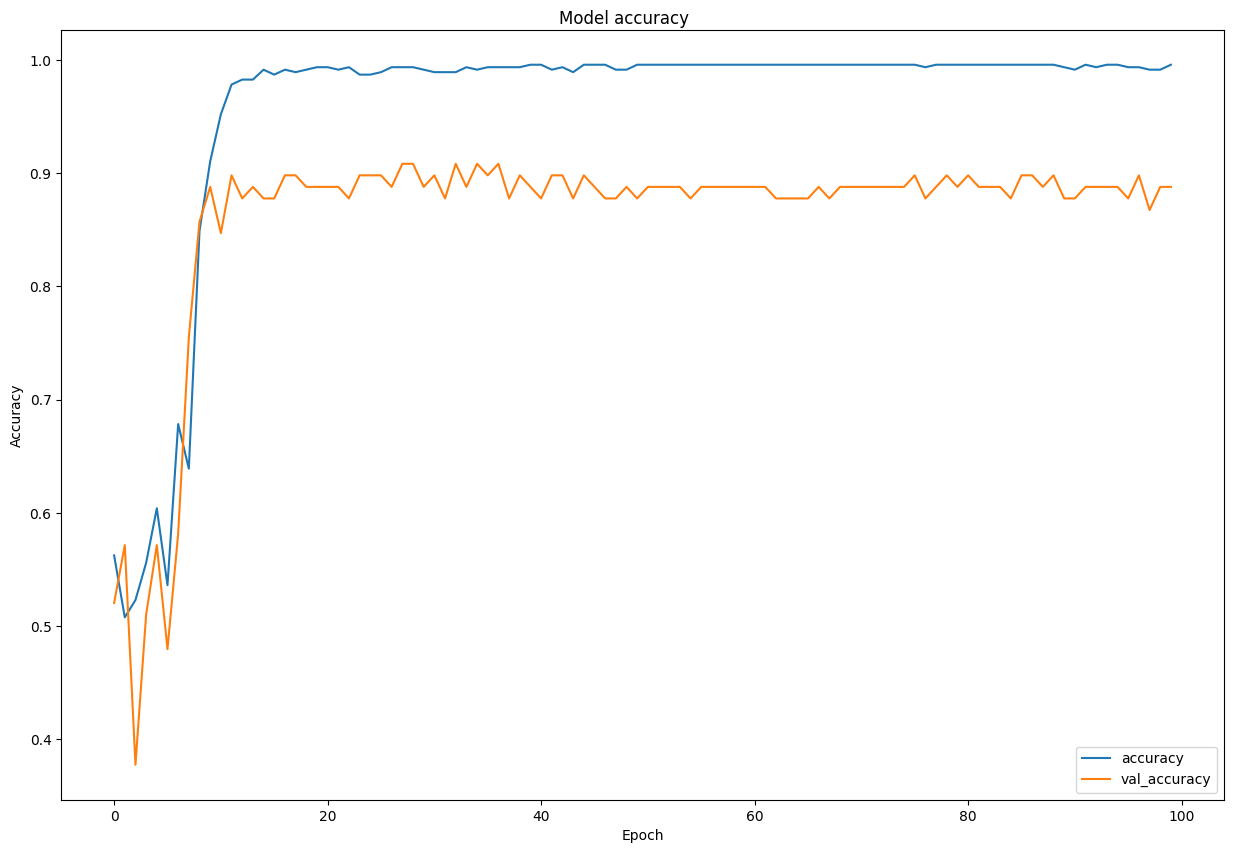

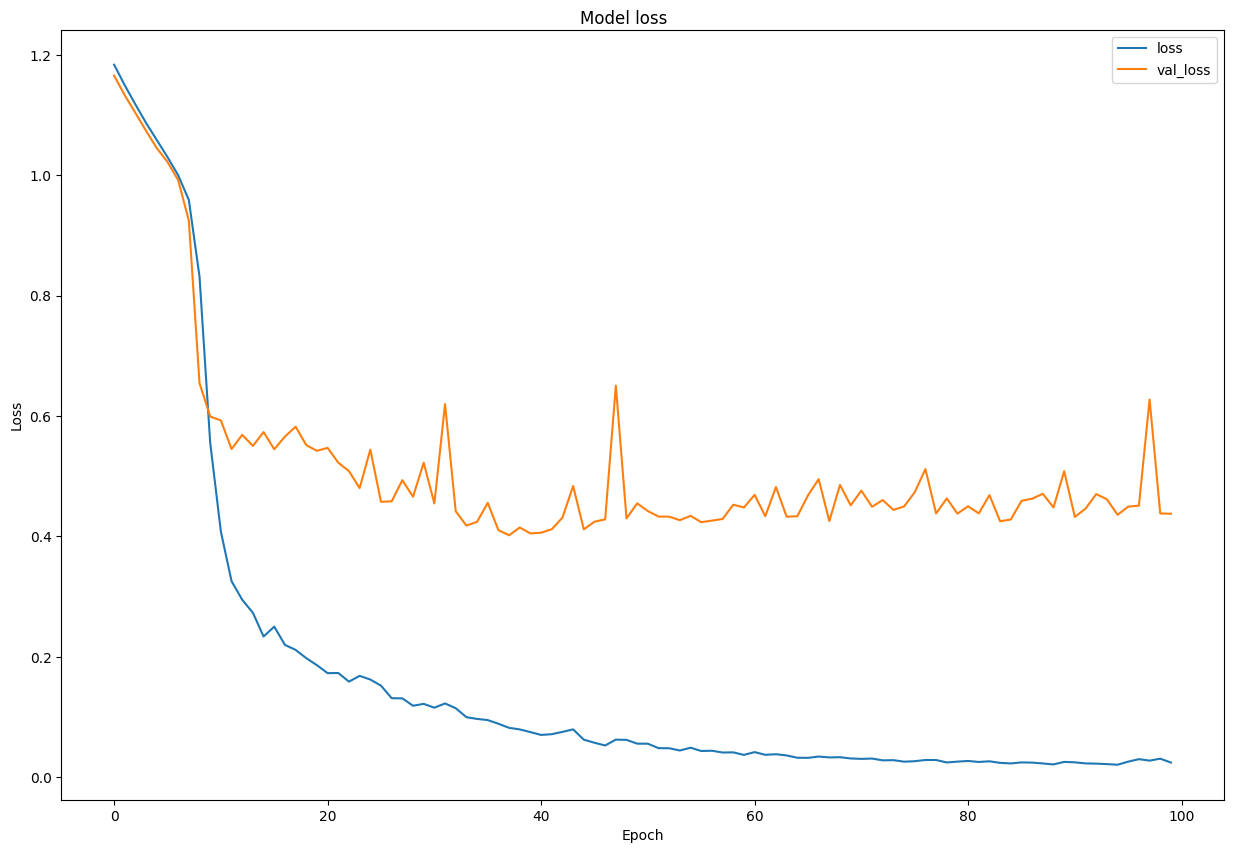

In [47]:
# Evaluate the model
model.evaluate(X_test, y_test)

# Plot the accuracy and loss of the model
fig = plt.figure(figsize = (15,10))
plt.suptitle("Model accuracy", y = 0.90)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

fig = plt.figure(figsize = (15,10))
plt.suptitle("Model loss", y = 0.90)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

From the model loss graph, there is no overfitting of the model onto the training data.

In [48]:
model.save('rnn.h5')
model.save_weights('rnn_weights.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 14, 100)           75600     
                                                                 
 bidirectional (Bidirectiona  (None, 14, 64)           34048     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 64)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4

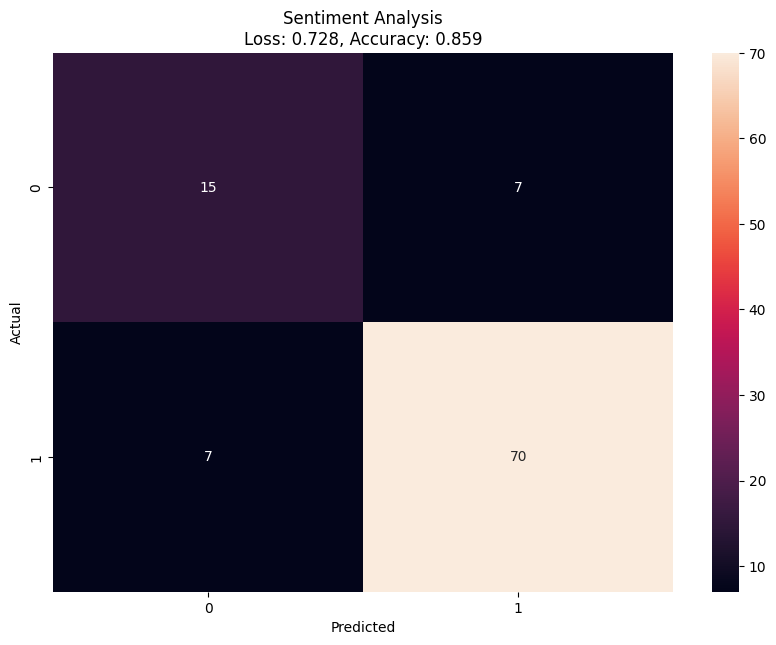

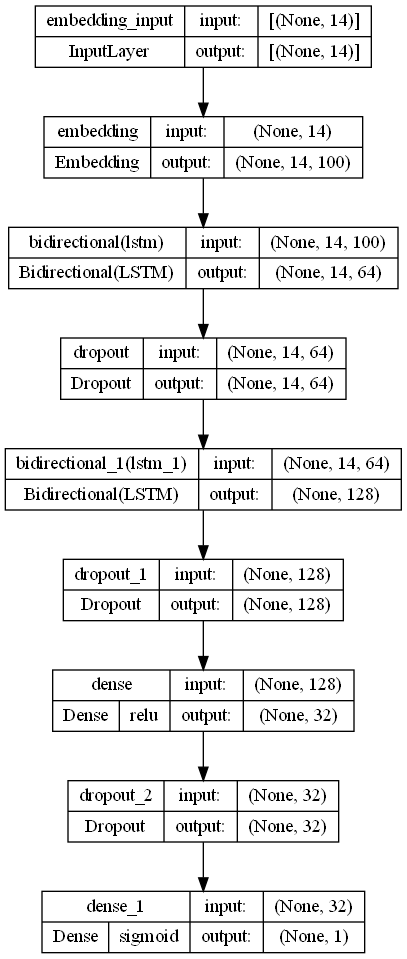

In [49]:
#import model and weights
from tensorflow.keras.models import load_model
from keras.utils.vis_utils import plot_model

model = load_model('rnn.h5')

model.load_weights('rnn_weights.h5')

model.summary()

y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

# Graph the confusion matrix

import seaborn as sns
import pandas as pd

cm = confusion_matrix(y_test, y_pred)

pd.options.display.float_format = '{:.2f}'.format

df_cm = pd.DataFrame(cm, index = [0,1],
                    columns = [0,1])

loss, accuracy = model.evaluate(X_test, y_test)

plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Sentiment Analysis\nLoss: {loss:.3f}, Accuracy: {accuracy:.3f}')
plt.show()

plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True, expand_nested=True)

The Model has a loss of 0.702 and an accuracy of 85.9% when tested on the testing data.

From the confusion matrix, you can see that the model classifies most of the images correctly. The number of images classified wrongly is the same for both positive and negative.